
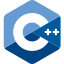
<br>

<div style="text-align:center; font-size:200%;">
  <b>Isolation of Unit Tests</b>
</div>
<br/>
<div style="text-align:center; font-size:120%;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">Coding-Academy Munich</div>
<br/>
<!-- 03 Isolation of Unit Tests.ipynb -->
<!-- slides/module_410_unit_testing/topic_160_test_isolation.cpp -->


## Unit Test: A Definition

- Tests a small piece of code (a **"unit"**)
- Runs quickly
- Is **isolated**


## What is a "Unit"?

- **A Behavior (Chicago/Classicist School):**
  - A "Unit of Behavior".
  - Often a group of collaborating classes that achieve a specific outcome.
  - Focuses on the *outcome* of an operation.

- **A Class (London/Mockist School):**
  - A "Unit of Code", typically a single class.
  - Focuses on the *interactions* of a class with its dependencies.


## What does "isolated" test mean?

- **Isolation between test cases (Chicago School):**
  - No test influences the outcome of another test.
  - Tests can be run in parallel and in any order.
  - Uses real objects as dependencies as long as they are fast and deterministic.

- **Isolation of the unit under test (London School):**
  - The class under test is isolated from the rest of the *production system*.
  - All dependencies are replaced by test doubles (especially mocks).

## Trade-offs: Chicago (Classicist) vs. London (Mockist)

|Feature                  |Chicago School (Classicist)                                  |London School (Mockist)                                     |
|-------------------------|-------------------------------------------------------------|------------------------------------------------------------|
|**Focus**                |State Verification                                           |Behavior Verification                                       |
|**Unit Under Test**      |A behavior (often multiple classes)                          |A single class                                              |
|**Test Doubles**         |Sparingly, for "inconvenient" dependencies (Stubs, Fakes)    |Extensively, for all dependencies (Mocks)                   |
|**Strengths**            |- Tests are resilient to refactoring                         |- Precise defect localization                               |
|                         |- Higher confidence in integration                           |- Drives decoupled design (Dependency Inversion)            |
|**Weaknesses**           |- Defect localization can be hard (cascading failures)       |- Tests are brittle to refactoring                          |
|                         |- Can require complex test setup                             |- Potential for integration gaps                            |
|**Design Direction**     |Often Inside-Out                                             | Often Outside-In                                           |


## Example: Detroit/Chicago School

- The `TicketOffice` class is tested together with the real `Event` class.
- The test verifies the *state* after the purchase.

In [ ]:
#include <iostream>
#include <stdexcept>
#include <string>
#include <unordered_map>
#include <vector>
#include <memory>
#include <map>
#include "check.h"

In [ ]:
namespace classicist {
class Event
{
private:
    std::string name{"Unnamed Event"};
    int capacity{};

public:
    Event() = default;
    Event(std::string name, int capacity) : name{name}, capacity{capacity} {}

    std::string get_name() const { return name; }
    int get_capacity() const { return capacity; }
    void purchase(int num_tickets) {
        if (num_tickets > capacity) {
            throw std::runtime_error("Not enough capacity");
        }
        capacity -= num_tickets;
    }
};
} // namespace classicist

In [ ]:
namespace classicist {
class TicketOffice
{
private:
    std::unordered_map<std::string, Event> events;

public:
    void add_event(Event event) { events[event.get_name()] = event; }
    Event get_event(const std::string& event_name) const { return events.at(event_name); }
    bool purchase_tickets(const std::string& event_name, int num_tickets) {
        if (events.count(event_name)) {
            try {
                events.at(event_name).purchase(num_tickets);
                return true;
            } catch (const std::runtime_error&) {
                return false;
            }
        }
        return false;
    }
};
} // namespace classicist

In [ ]:
namespace classicist {
void test_purchase_succeeds_and_reduces_capacity()
{
    // Arrange
    TicketOffice office;
    office.add_event(Event("CppCon", 100));

    // Act
    bool result = office.purchase_tickets("CppCon", 10);

    // Assert
    check(result == true, "Purchase should succeed");
    check(office.get_event("CppCon").get_capacity() == 90, "Capacity should be reduced by 10");
}
} // namespace classicist

In [ ]:
classicist::test_purchase_succeeds_and_reduces_capacity();

## Example: London School

- `TicketOffice` is isolated, `Event` is replaced by a mock.
- The test verifies the *interaction* with the mock.

In [ ]:
namespace mockist {
class Event {
public:
    virtual ~Event() = default;
    virtual std::string get_name() const = 0;
    virtual void purchase(int num_tickets) = 0;
};

// Actual implementation of Event interface skipped for brevity...
} // namespace mockist

In [ ]:
namespace mockist {
class TicketOffice {
private:
    std::unordered_map<std::string, std::unique_ptr<Event>> events;
public:
    void add_event(std::unique_ptr<Event> event) {
        events[event->get_name()] = std::move(event);
    }
    Event& get_event(const std::string& event_name) const {
        return *events.at(event_name);
    }
    bool purchase_tickets(const std::string& event_name, int num_tickets) {
        if (events.count(event_name)) {
            events.at(event_name)->purchase(num_tickets);
            return true;
        }
        return false;
    }
};
} // namespace mockist

In [ ]:
namespace mockist
{
class EventMock : public Event {
public:
    std::vector<int> purchase_call_args;
    std::string name = "CppCon";

    std::string get_name() const override { return name; }
    void purchase(int num_tickets) override {
        purchase_call_args.push_back(num_tickets);
    }
};
} // namespace mockist

In [ ]:
namespace mockist
{
void test_purchase_delegates_to_event()
{
    // Arrange
    TicketOffice office;
    auto mock = std::make_unique<EventMock>();
    auto* mock_ptr = mock.get(); // Raw pointer for observing
    office.add_event(std::move(mock));

    // Act
    bool result = office.purchase_tickets("CppCon", 10);

    // Assert
    check(result == true, "Purchase should succeed");
    check(mock_ptr->purchase_call_args.size() == 1, "purchase() should be called once");
    check(mock_ptr->purchase_call_args.at(0) == 10, "purchase() should be called with 10");
}
} // namespace mockist

In [ ]:
mockist::test_purchase_delegates_to_event();


## Recommendation: A Pragmatic Middle Ground

The choice between Chicago and London is not dogma, but a context-dependent
decision.


- **Use the Chicago (Classicist) style for your core application logic:**
  - For domain models, value objects, algorithms.
  - Here, the outcome is important, and tests should survive refactoring.

- **Use the London (Mockist) style at the boundaries of your system:**
  - For controllers, service orchestrators, gateways to external services.
  - Here, coordination is the main responsibility, so testing interactions is meaningful.


**The Golden Rule:**

- Isolate only when it becomes painful.
- Start with the simpler classicist approach
- Introduce mocks only when you have a dependency that is
  - slow,
  - non-deterministic, or
  - difficult to set up.


## Workshop: Intelligent Vending Machine

- **Goal:** To test a `VendingMachine` that manages its own stock.
- We will do this in both the Chicago and London styles.

- **Scenario:**
  - A `VendingMachine` checks its `Inventory`.
  - If an item's stock is low, an `OrderStrategy` is used to determine a
    reorder.
  - This order is then sent to an `IOrderService`.

- **Notes:**
  - You can also approach this task using TDD.
  - A starter kit is available at `code/starter_kits/vending_machine_sk`.

### Part 1: Chicago (Classicist) Style

**Task:**
- Define the classes as described below.
- Use test-driven development.
- Try to write the tests in the Chicago style, using real objects and
  avoiding mocks where possible.

In [ ]:
#include <iostream>
#include <stdexcept>
#include <string>
#include <unordered_map>
#include <vector>
#include <memory>
#include <map>
#include "check.h"

In [ ]:
namespace chicago_vending {
struct Item
{
    std::string name;
    int current_stock;
    int capacity;
};
}

In [ ]:
namespace chicago_vending {
using Order = std::map<std::string, int>;
}


Define the `Inventory` class, which contains a collection of `Item` objects.
It should have the following methods:

- `void add_item(const Item& item)`: Adds an `Item` to the inventory.
- `const Item& get_item(const std::string& name) const`: Returns an `Item`
  by its name. If the `Item` is not found, it should throw an exception.

Use TDD to write the code.

In [ ]:
namespace chicago_vending {
class Inventory {
public:
    std::map<std::string, Item> items;
    void add_item(const Item& item) { items[item.name] = item; }
    const Item& get_item(const std::string& name) const {
        if (items.count(name) == 0) {
            throw std::runtime_error("Item not found");
        }
        return items.at(name);
    }
};
}

In [ ]:
namespace chicago_vending {
void test_add_and_get_item() {
    // Arrange
    Inventory inventory;
    Item cola{"Cola", 10, 20};
    inventory.add_item(cola);
    // Act
    const Item& retrieved = inventory.get_item("Cola");
    // Assert
    check(retrieved.name == "Cola", "Item name should match");
    check(retrieved.current_stock == 10, "Current stock should match");
    check(retrieved.capacity == 20, "Capacity should match");

    std::cout << "test_add_and_get_item() passed.\n";
}
}

In [ ]:
chicago_vending::test_add_and_get_item();


Define the `OrderStrategy` class, which has the following method:

- `Order compute_order(const Inventory& inventory, double threshold) const`:
  - This method takes an `Inventory` object and a threshold (between 0 and 1).
  - It should return an `Order` containing all items whose current stock is
    below the threshold.

In [ ]:
namespace chicago_vending {
class OrderStrategy {
public:
    Order compute_order(const Inventory& inventory, double threshold) const {
        Order order{};
        for (const auto& pair : inventory.items) {
            const auto& item = pair.second;
            if (static_cast<double>(item.current_stock) / item.capacity < threshold) {
                order[item.name] = item.capacity - item.current_stock;
            }
        }
        return order;
    }
};
}

In [ ]:
namespace chicago_vending {
void test_compute_order() {
    // Arrange
    Inventory inventory;
    inventory.add_item({"Cola", 2, 20});
    inventory.add_item({"Water", 15, 20});
    OrderStrategy strategy;
    // Act
    Order order = strategy.compute_order(inventory, 0.25);
    // Assert
    check(order.size() == 1, "Order should contain one item");
    check(order.count("Cola") == 1, "Order should contain Cola");
    check(order.at("Cola") == 18, "Order should restock 18 Colas");
    check(order.count("Water") == 0, "Order should not contain Water");
}
}

In [ ]:
chicago_vending::test_compute_order();


- Define an `IOrderService` interface, with the following pure virtual
  method:
- `bool place_order(const Order& order)`.
  - This method should accept and process an order.
  - It should return `true` if the order was successfully placed, or `false`
    if there was an error.

In [ ]:
namespace chicago_vending {
class IOrderService {
public:
    virtual ~IOrderService() = default;
    virtual bool place_order(const Order& order) = 0;
};
}


Implement a `FakeOrderService` that implements the `IOrderService`
interface and stores all orders in a vector.

In [ ]:
namespace chicago_vending {
class FakeOrderService : public IOrderService {
public:
    std::vector<Order> placed_orders;
    bool place_order(const Order& order) override {
        placed_orders.push_back(order);
        return true; // Simulate successful order placement
    }
};
}


Define the `VendingMachine` class, which has the following methods:

- `int get_stock(const std::string& item_name) const`:
  - This method should return the current stock of an item.
  - If the item is not found, it should throw an exception.
- `void sell(const std::string& item_name, int quantity)`:
  - This method should sell an item if enough stock is available.
  - If there is not enough stock, it should throw an exception.
- `void check_and_restock(double threshold)`:
  - This method should check the inventory and trigger a reorder if needed.
  - If the order is successful, it should update the stock of the items
    in the inventory.
  - If the order fails, it should throw an exception.

Use test-driven development and write the tests in the Chicago style,
using real objects and avoiding mocks where possible.

In [ ]:
namespace chicago_vending {
class VendingMachine {
private:
    Inventory inventory; // Held by value
    OrderStrategy strategy; // Held by value
    std::shared_ptr<IOrderService> order_service;
public:
    VendingMachine(const Inventory& inv, const OrderStrategy& strat, std::shared_ptr<IOrderService> service)
        : inventory(inv), strategy(strat), order_service(std::move(service)) {}

    int get_stock(const std::string& item_name) const;
    void sell(const std::string& item_name, int quantity);
    void check_and_restock(double threshold);
};
}

In [ ]:
namespace chicago_vending {
int VendingMachine::get_stock(const std::string& item_name) const {
    if (inventory.items.count(item_name) == 0) {
        throw std::runtime_error("Item not found");
    }
    return inventory.items.at(item_name).current_stock;
}
}

In [ ]:
namespace chicago_vending {
void VendingMachine::sell(const std::string& item_name, int quantity) {
    int stock = get_stock(item_name);
    if (stock < quantity) {
        throw std::runtime_error("Not enough stock");
    }
    auto& item = inventory.items.at(item_name);
    item.current_stock -= quantity;
}
}

In [ ]:
namespace chicago_vending {
void VendingMachine::check_and_restock(double threshold) {
    Order order = strategy.compute_order(inventory, threshold);
    if (!order.empty()) {
        bool order_successful = order_service->place_order(order);
        if (order_successful) {
            for (const auto& [item_name, quantity] : order) {
                if (inventory.items.count(item_name) == 0) {
                    throw std::runtime_error("Ordered item not found in inventory");
                }
                inventory.items[item_name].current_stock += quantity;
            }
        } else {
            throw std::runtime_error("Order placement failed");
        }
    }
}
}

In [ ]:
namespace chicago_vending {
    void test_get_stock() {
        // Arrange
        Inventory inventory;
        inventory.add_item({"Cola", 10, 20});
        VendingMachine machine(inventory, OrderStrategy(), std::make_shared<FakeOrderService>());

        // Act
        int stock = machine.get_stock("Cola");

        // Assert
        check(stock == 10, "Stock should be 10");
    }
}

In [ ]:
chicago_vending::test_get_stock();

In [ ]:
namespace chicago_vending {
void test_restocks_low_items_based_on_strategy() {
    // Arrange
    Inventory inventory;
    inventory.add_item({"Cola", 2, 20});
    inventory.add_item({"Water", 15, 20});

    OrderStrategy strategy;
    std::shared_ptr<FakeOrderService> fake_service{std::make_shared<FakeOrderService>()};
    VendingMachine machine(inventory, strategy, fake_service);

    // Act
    machine.check_and_restock(0.25);

    // Assert
    check(machine.get_stock("Cola") == 20, "Stock of Cola should have been restocked to 20.");
    check(machine.get_stock("Water") == 15, "Stock of Water should remain unchanged at 15.");
    check(fake_service->placed_orders.size() == 1, "An order should have been placed.");
    const auto& placed_order = fake_service->placed_orders[0];
    check(placed_order.count("Cola") == 1, "Order should contain Cola.");
    check(placed_order.at("Cola") == 18, "Order should restock 18 Colas.");
    check(placed_order.count("Water") == 0, "Order should not contain Water.");
    std::cout << "Chicago style test finished and passed.\n";
}
}

In [ ]:
chicago_vending::test_restocks_low_items_based_on_strategy()

### Part 2: London (Mockist) Style

**Task:**
- Refactor the code. `VendingMachine` should depend on interfaces
  (`IInventory`, `IOrderStrategy`, `IOrderService`), not concrete classes.
- Implement mocks for all three interfaces. The mocks should record which
  methods were called.
- Write tests in the London style, i.e., replace the real objects with mocks
  and verify the interactions.

In [ ]:
#include <iostream>
#include <stdexcept>
#include <string>
#include <unordered_map>
#include <vector>
#include <memory>
#include <map>
#include "check.h"

In [ ]:
namespace london_vending {
class IItem {
public:
        virtual ~IItem() = default;
        virtual std::string get_name() const = 0;
        virtual int get_current_stock() const = 0;
        virtual void set_current_stock(int stock) = 0;
        virtual int get_capacity() const = 0;
};
}

In [ ]:
namespace london_vending {
class Item : public IItem
{
    std::string name;
    int current_stock;
    int capacity;
public:
    Item(std::string name, int current_stock, int capacity)
        : name(std::move(name)), current_stock(current_stock), capacity(capacity) {}

    std::string get_name() const override { return name; }
    int get_current_stock() const override { return current_stock; }
    void set_current_stock(int stock) override { current_stock = stock; }
    int get_capacity() const override { return capacity; }
};
}

In [ ]:
namespace london_vending {
using Order = std::map<std::string, int>;
}

In [ ]:
namespace london_vending {
class IInventory {
public:
    virtual ~IInventory() = default;
    virtual void add_item(std::unique_ptr<IItem> item) = 0;
    virtual const IItem& get_item(const std::string& name) const = 0;
    virtual IItem& get_item(const std::string& name) = 0;
};
}

In [ ]:
namespace london_vending {
class IOrderStrategy {
public:
    virtual ~IOrderStrategy() = default;
    virtual Order compute_order(const IInventory& inventory, double threshold) const = 0;
};
}

In [ ]:
namespace london_vending {
class IOrderService {
public:
    virtual ~IOrderService() = default;
    virtual bool place_order(const Order& order) = 0;
};
}

In [ ]:
// 2. VendingMachine depends on abstractions
namespace london_vending {
class VendingMachine {
private:
    std::unique_ptr<IInventory> inventory;
    std::shared_ptr<IOrderStrategy> strategy;
    std::shared_ptr<IOrderService> order_service;
public:
    VendingMachine(std::unique_ptr<IInventory> inv, std::shared_ptr<IOrderStrategy> strat, std::shared_ptr<IOrderService> service)
        : inventory(std::move(inv)), strategy(std::move(strat)), order_service(std::move(service)) {}

    int get_stock(const std::string& item_name) const;
    void sell(const std::string& item_name, int quantity);
    void check_and_restock(double threshold);
};
}

In [ ]:
namespace london_vending {
int VendingMachine::get_stock(const std::string& item_name) const {
    const auto& item = inventory->get_item(item_name);
    return item.get_current_stock();
}
}

In [ ]:
namespace london_vending {
void VendingMachine::sell(const std::string& item_name, int quantity) {
    IItem& item = inventory->get_item(item_name);
    int stock = item.get_current_stock();
    if (stock < quantity) {
        throw std::runtime_error("Not enough stock");
    }
    item.set_current_stock(stock - quantity);
}
}

In [ ]:
namespace london_vending {
void VendingMachine::check_and_restock(double threshold) {
    Order order = strategy->compute_order(*inventory, threshold);
    if (!order.empty()) {
        bool order_successful = order_service->place_order(order);
        if (order_successful) {
            for (const auto& [item_name, quantity] : order) {
                auto& item = inventory->get_item(item_name);
                item.set_current_stock(item.get_current_stock() + quantity);
            }
        } else {
            throw std::runtime_error("Order placement failed");
        }
    }
}
}

In [ ]:
// 3. Mocks for testing
namespace london_vending {
class MockInventory : public IInventory
{
public:
    std::unordered_map<std::string, std::unique_ptr<IItem>> items;

    void add_item(std::unique_ptr<IItem> item) override {
        if (!item) {
            throw std::runtime_error("Cannot add null item");
        }
        items[item->get_name()] = std::move(item);
    }

    const IItem& get_item(const std::string& name) const override {
        if (items.count(name) == 0) {
            throw std::runtime_error("Item not found");
        }
        return *items.at(name);
    }

    IItem& get_item(const std::string& name) override {
        if (items.count(name) == 0) {
            throw std::runtime_error("Item not found");
        }
        return *items.at(name);
    }
};
}

In [ ]:
namespace london_vending {
class MockOrderService : public IOrderService {
public:
    bool place_order_called = false;
    Order last_order;
    bool place_order(const Order& order) override {
        place_order_called = true;
        last_order = order;
        return true;
    }
};
}

In [ ]:
namespace london_vending {
class MockOrderStrategy : public IOrderStrategy {
public:
    // Need to initialize order_to_return in the constructor because of a bug
    // in the xeus-jupyter kernel used for slide processing.
    MockOrderStrategy() : order_to_return{} {
        order_to_return["Cola"] = 18; // Default mock behavior
    }

    mutable bool compute_order_called = false;
    Order order_to_return;

    Order compute_order(const IInventory& inventory, double threshold) const override {
        this->compute_order_called = true;
        return order_to_return;
    }
};
}

In [ ]:
namespace london_vending {
void test_check_and_restock_delegates_to_collaborators() {
    // Arrange
    std::unique_ptr<MockInventory> mock_inventory = std::make_unique<MockInventory>();
    mock_inventory->add_item(std::make_unique<Item>("Cola", 2, 20));
    mock_inventory->add_item(std::make_unique<Item>("Water", 15, 20));
    std::shared_ptr<MockOrderStrategy> mock_strategy = std::make_shared<MockOrderStrategy>();
    std::shared_ptr<MockOrderService> mock_service = std::make_shared<MockOrderService>();
    VendingMachine machine(std::move(mock_inventory), mock_strategy, mock_service);

    // Act
    machine.check_and_restock(0.25);

    // Assert
    check(mock_strategy->compute_order_called, "strategy->compute_order() should have been called.");
    check(mock_service->place_order_called, "service->place_order() should have been called.");
    check(mock_service->last_order.count("Cola") == 1, "The order from the strategy should have been passed to the service.");
    check(mock_service->last_order.at("Cola") == 18, "The order data should be correct.");
    std::cout << "London style test finished and passed.\n";
}
}

In [ ]:
london_vending::test_check_and_restock_delegates_to_collaborators();